In [1]:
## https://dataplatform.cloud.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c

In [2]:
# Importing

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [24]:
# Reading excel and creating dataframe
# Converting date format

df = pd.read_excel('Desktop/testoutput3.xlsx', sheet_name = 'Sheet4')
df = pd.DataFrame({'Date' : df['Date'], 'Glucose' : df['Glucose']})
df['Date'] = pd.to_datetime(df['Date'], format= '%Y-%m-%d')
df

,Date,Glucose
0,2017-05-24,91
1,2016-01-14,93
2,2016-06-08,87
3,2016-10-18,97
4,2017-07-24,67
5,2016-10-16,85
6,2017-09-09,76
7,2017-09-18,69
8,2016-11-09,129
9,2017-11-11,88


In [26]:
# Grouping by date
# Excluding Date = 2018-04-10, as it is an outlier

df = df.groupby('Date')['Glucose'].mean().reset_index()
df = df[df.Date != '2018-04-10']
df

,Date,Glucose
0,2016-01-05,240.000000
1,2016-01-07,90.000000
2,2016-01-09,127.000000
3,2016-01-11,98.000000
4,2016-01-13,68.000000
5,2016-01-14,80.000000
6,2016-01-15,58.000000
7,2016-01-16,108.666667
8,2016-01-26,87.000000
9,2016-01-27,76.000000


In [5]:
# Setting index

df = df.set_index('Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 429 entries, 2016-01-05 to 2017-12-30
Data columns (total 1 columns):
Glucose    429 non-null float64
dtypes: float64(1)
memory usage: 6.7 KB


In [6]:
# Resampling by day
# Filling days with null with 100

y = df['Glucose'].resample('D').mean()
y = y.fillna(100)
#y = y.dropna()
y

Date
2016-01-05    240.000000
2016-01-06    100.000000
2016-01-07     90.000000
2016-01-08    100.000000
2016-01-09    127.000000
2016-01-10    100.000000
2016-01-11     98.000000
2016-01-12    100.000000
2016-01-13     68.000000
2016-01-14     80.000000
2016-01-15     58.000000
2016-01-16    108.666667
2016-01-17    100.000000
2016-01-18    100.000000
2016-01-19    100.000000
2016-01-20    100.000000
2016-01-21    100.000000
2016-01-22    100.000000
2016-01-23    100.000000
2016-01-24    100.000000
2016-01-25    100.000000
2016-01-26     87.000000
2016-01-27     76.000000
2016-01-28    100.000000
2016-01-29    100.000000
2016-01-30     80.500000
2016-01-31    100.000000
2016-02-01    100.000000
2016-02-02    100.000000
2016-02-03    100.000000
                 ...    
2017-12-01    110.000000
2017-12-02     87.800000
2017-12-03    100.000000
2017-12-04     95.000000
2017-12-05    100.000000
2017-12-06    102.000000
2017-12-07    129.000000
2017-12-08    100.000000
2017-12-09     76.00

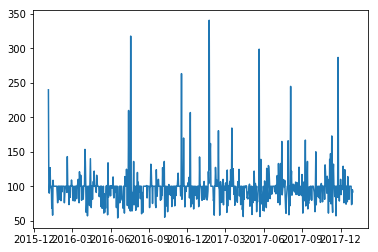

In [7]:
# Plotting

plt.plot(y.index.to_pydatetime(), y.values)

In [8]:
# Stationary Time Series, is when the statistical properties over time is
# constant and autocovariance must be time independent.

def check_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=52,center=False).mean() 
    rolling_std = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    original = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)'%key] = value
    print (dfresults)

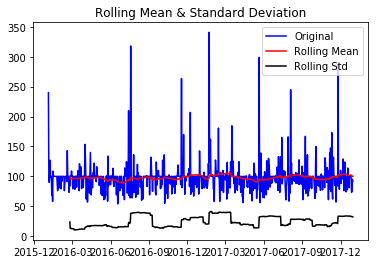

Results of Dickey-Fuller Test:
Test Statistic                 -27.340981
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    725.000000
Critical Value (1%)             -3.439402
Critical Value (5%)             -2.865535
Critical Value (10%)            -2.568897
dtype: float64


In [9]:
check_stationarity(y)

In [10]:
# Nonlinear log transformation

y_log = np.log(y)

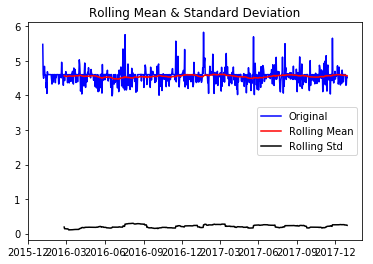

Results of Dickey-Fuller Test:
Test Statistic                 -26.917741
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    725.000000
Critical Value (1%)             -3.439402
Critical Value (5%)             -2.865535
Critical Value (10%)            -2.568897
dtype: float64


In [11]:
check_stationarity(y_log)

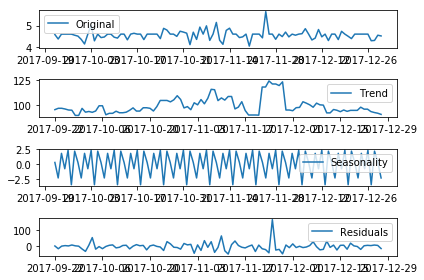

In [12]:
# Decompose the time series to remove trend and seasonality from the data.

decomposition = seasonal_decompose(y)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Select the most recent weeks 
y_log_select = y_log[-100:]

plt.subplot(411)
plt.plot(y_log_select.index.to_pydatetime(), y_log_select.values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(y_log_select.index.to_pydatetime(), trend[-100:].values, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(y_log_select.index.to_pydatetime(), seasonal[-100:].values,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(y_log_select.index.to_pydatetime(), residual[-100:].values, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

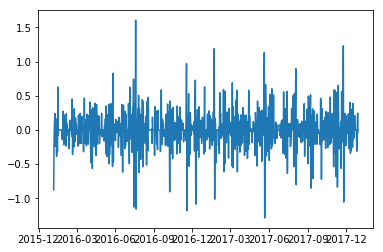

In [13]:
# Differencing is a method of dealing with both trend and seasonality
# Compute the difference between consecutive observations in the time series.

y_log_diff = y_log - y_log.shift()
plt.plot(y_log_diff.index.to_pydatetime(), y_log_diff.values)

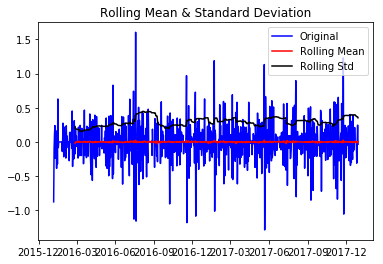

Results of Dickey-Fuller Test:
Test Statistic                -1.010850e+01
p-value                        1.014885e-17
#Lags Used                     2.000000e+01
Number of Observations Used    7.040000e+02
Critical Value (1%)           -3.439673e+00
Critical Value (5%)           -2.865654e+00
Critical Value (10%)          -2.568961e+00
dtype: float64


In [14]:
y_log_diff.dropna(inplace=True)
check_stationarity(y_log_diff)

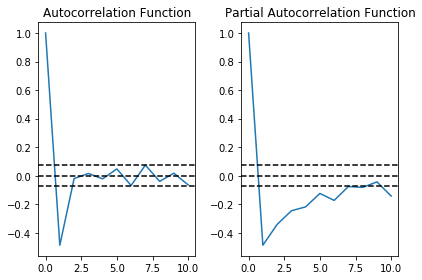

In [15]:
lag_auto_corr = acf(y_log_diff, nlags=10)
lag_par_auto_corr = pacf(y_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_auto_corr)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='black')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_par_auto_corr)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(y_log_diff)),linestyle='--',color='black')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [16]:
# p: The value where PACF cuts off 0
# d: No. of differences of non-seasonal differences. In this case, d=1.
# q: The value where ACF cross the upper confidence interval for the 1st time.
# ARIMA(p,d,q) are (1,1,1)

model = ARIMA(y_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1) 

Text(0.5,1,'RSS: 33.5128')

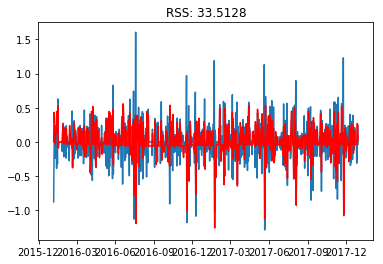

In [17]:
model = ARIMA(y_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(y_log_diff.index.to_pydatetime(), y_log_diff.values)
plt.plot(y_log_diff.index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-y_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:              D.Glucose   No. Observations:                  725
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  90.009
Method:                       css-mle   S.D. of innovations              0.213
Date:                Thu, 15 Nov 2018   AIC                           -172.018
Time:                        13:24:15   BIC                           -153.673
Sample:                    01-06-2016   HQIC                          -164.938
                         - 12-30-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.727e-05   3.82e-05      0.714      0.475   -4.75e-05       0.000
ar.L1.D.Glucose     0.0127      0.038      0.339      0.735      -0.061       0.087
ma.L1.D.Glucose    -1.0000      

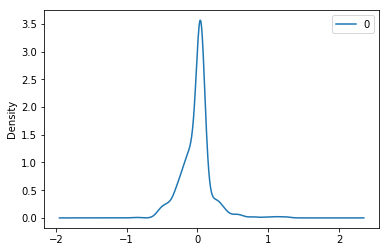

In [18]:
# Small RSS indicates that the model fits tightly to the data

print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [19]:
y_predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (y_predictions_ARIMA_diff.head())

Date
2016-01-06    0.000027
2016-01-07    0.432196
2016-01-08    0.358584
2016-01-09    0.191693
2016-01-10   -0.034834
Freq: D, dtype: float64


In [20]:
y_predictions_ARIMA_diff_cumsum = y_predictions_ARIMA_diff.cumsum()
y_predictions_ARIMA_log = pd.Series(y_log.iloc[0], index=y_log.index)
y_predictions_ARIMA_log = y_predictions_ARIMA_log.add(y_predictions_ARIMA_diff_cumsum,fill_value=0)

Text(0.5,1,'RMSE: 264405.5083')

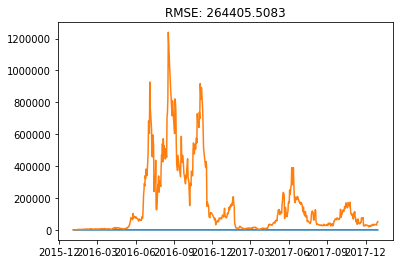

In [21]:
y_predictions_ARIMA = np.exp(y_predictions_ARIMA_log)
plt.plot(y.index.to_pydatetime(), y.values)
plt.plot(y.index.to_pydatetime(), y_predictions_ARIMA.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((y_predictions_ARIMA-y)**2)/len(y)))

In [22]:
size = int(len(y_log) - 15)
train, test = y_log[0:size], y_log[size:len(y_log)]
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(historical, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted Glucose Level = %f, Expected Glucose Level = %f' % (np.exp(yhat), np.exp(observed)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

y_predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


Predicted Glucose Level = 96.676813, Expected Glucose Level = 100.000000
Predicted Glucose Level = 96.699095, Expected Glucose Level = 77.500000
Predicted Glucose Level = 96.334891, Expected Glucose Level = 114.000000
Predicted Glucose Level = 96.784391, Expected Glucose Level = 100.000000
Predicted Glucose Level = 96.694104, Expected Glucose Level = 90.333333
Predicted Glucose Level = 96.572289, Expected Glucose Level = 81.000000
Predicted Glucose Level = 96.379689, Expected Glucose Level = 100.000000
Predicted Glucose Level = 96.591995, Expected Glucose Level = 100.000000
Predicted Glucose Level = 96.614152, Expected Glucose Level = 100.000000
Predicted Glucose Level = 96.635909, Expected Glucose Level = 100.000000
Predicted Glucose Level = 96.657561, Expected Glucose Level = 100.000000
Predicted Glucose Level = 96.679104, Expected Glucose Level = 73.333333
Predicted Glucose Level = 96.264453, Expected Glucose Level = 74.333333
Predicted Glu